<a href="https://colab.research.google.com/github/jamg-upv/Impacto-citas-articulo/blob/V1/impactoencitas_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to cite this work:



------------
Referencias: 
Documento compartidoen drive

Miro: https://miro.com/app/board/uXjVOVj0st4=/?moveToWidget=3458764518530820364&cot=14

Este codigo permite integrar una tabla con los datos de un conjunto de articulos y sus numeros de citas, normalizarlas teniendo en cuenta las tablas de citas mundiales (scopus) o baseline de (WOS), y añadir las métricas de impacto de la revista en el año de publicación del articulo.
Son necesarias 3 tablas para cada proveedor (scopus y WOS)
El Código integra los datos de 5 tablas (lista de articulos por DOI, descarga de datos y métricas de articulo en escopus, datos y metrica de articulos en WOS, metricas de revista scopus y metricas de revista WOS) y los presentar en una unica tabla donde cada fila es un articulo.


Fuente de datos SCOPUS https://elsevier.com/?a=734751


Tareas 
1. Lista de 25 DOIs Banco de Pruebas1  (meritos (5 autores "al azar") )
2. Descargar como cvs bancopruebas1sco tabla Scopus  de 25 meritos (5 autores "al azar") a partir de los DOI
1. Descargar como cvs bancopruebas1wos tabla WOS de los 25 meritos a partir de los DOI
1. preparar un prototipo de la tabla que penamos crear para consultar a compañeros del equipo
2.   



Pasos previos. Librerias y configuración

In [24]:
# Importamos ls librería de Python que necesitaremos en este notebook

import pandas as pd  # Pandas permite manipular tablas 
import matplotlib.pyplot as plt  # Para hacer gráficas
import seaborn as sns  # Para hacer gráficas pero necesita matplotlib y deja unos graficos chulisismos 
sns.set_style('whitegrid')  # Pone una malla de fondo bastante mona para Seaborn
import numpy as np
import openpyxl #para abrir y grabar Excel con pandas

from pandas import ExcelWriter
from pandas import ExcelFile

import os #rename files
#import xlwings as xw #permite leer docuemtnos xlb me da error y no lo puedo instalar

# Redondeamos las salidas a dos decimales
%precision %.2f

# from google.colab import drive
# drive.mount('/content/drive')



'%.2f'

Carga de *datos* Indicadores de revistas SCOPUS

## No usado 

In [ ]:
#métricas de revistas Scopus

# descarga de alfresco con el nombre de fichero que quiera guardarlo
!wget --output-document=CiteScore14_20.xlsx https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/egXj6G-GT0WY_g3O-2_swA
#si lo hago manual, que tarda varios minutos en subir cada vez) con Wget en pocos segundos está cargado en el entonrno

# en general funciona mejor con archivos csv, que con excel. tendre que partir el archivo excel en csv

#renbombrar el fichero local descargado para que no sea tan feote
#os.rename(r'/content/edit?usp=sharing',r'/content/scopus.xlsx')

--2022-02-10 17:37:12--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/egXj6G-GT0WY_g3O-2_swA
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 62207801 (59M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘CiteScore14_20.xlsx’

CiteScore14_20.xlsx 100%[===================>]  59.33M  6.44MB/s    in 15s     

2022-02-10 17:37:27 (4.07 MB/s) - ‘CiteScore14_20.xlsx’ saved [62207801/62207801]



In [ ]:
# unos 150seg en cargar el dataframe)
# me sirve para comprobar el tamaño de filas en cada conjunto de años con los que tengo en el CVS (o puedo directamente trabajar con este dataframe)

dfs = pd.read_excel('/content/CiteScore14_20.xlsx',engine='openpyxl',sheet_name=None)
dfs

In [ ]:
# Otra forma de hacer exactamente lo mismo de arriba (130 segundo) (puede llegar a 180seg)
# creo un objeto tipo DICT

xl_file = pd.ExcelFile('/content/CiteScore14_20.xlsx')

dfs2 = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
dfs2

In [ ]:
##pendiente automtizar la creación de un CSV a partir de las pestañas, añadiendo una columna del año (y rotulando citescore solo sin años en las columnas de datos)

# Usado una vez PAra Scopus (luego continuo conla excel producida) Con WOs no es necesario porque ya tengo los 10 años en una tabla
Preparacion de las pestañas d la excel
Quitar espacioes en los rotulos del encabezado
Estandarizar los nombres de las columnas

ScopusSourceID	Title	CitationCount	ScholarlyOutput	PercentCited	CiteScore	SNIP	SJR	ScopusASJCCode	ScopusSubSubjectArea	Percentile	RANK	RankOutOf	Publisher	Type	OpenAccess	Quartile	Top10	URLScopusSourceID	PrintISSN	ElectISSN


In [ ]:
#DEPRICATED
# si lo descargamos directo de la web Ç(ventaja es que con una descarga siempre está accesible y no hay que volver a descargarlo durante la sesión)
# el archivo de SCopus de 10 años ocupa demasiados GB (60gb) y no se puede alojar en drive (no debería esar en un acceso libre en github porque es propiedad de Scopus)
   #!wget https://elsevier.com/?a=734751 
#es XLB, hay que convertirlo a mano XLS porque xlb requiere de librerias que no tengo instaladas en colab
# y hacerlo accesible aquí
#la primer pesaña son definiciones de indicadores, la segunda el el año más reciente y luego 9 mas con los anteriores. La ultima pestaña es un clasificación de categorias
## depricated_Puedo limpiar a mano las pestañas no usadas (priemera y ultima) y dejo solo los 7 años más recientes (para que sean solo 44mb y me quepa en google drive)--> pero no sirve porque luego no lee bien porque googledrive CONVIERTE a formato propio



In [ ]:
# abro el xlb a mano y lo convierto en Excel, Aprovecho para Preparacion de las pestañas d la excel quitando espacioes en los rotulos del encabezado Estandarizar los nombres de las columnas

# ScopusSourceID Title CitationCount ScholarlyOutput PercentCited CiteScore SNIP SJR ScopusASJCCode 
# ScopusSubSubjectArea Percentile RANK RankOutOf Publisher Type OpenAccess Quartile Top10 
# URLScopusSourceID PrintISSN ElectISSN

# Subo a Alfresco (que permite leerlo como un xls)

In [ ]:
# importar tablas de metricas revisas SCOPUS (la excel original la he convertido en un CVS por cada pestaña)
# hay que importar los csv y ñadir a cada uno un campo con el año y luego fusionarlos en una tabla unica o trabajarlos como tablas separadas (no sé que será más eficiente)
# El csv subido a Github no funciona (crea tags de html en el archivo y no se lee luego con pandas. Lo lee pero los nombres de los ficheros no son intuitivos)
# !wget https://github.com/jamg-upv/Impacto-citas-articulo/blob/main/tablasinput/CiteScore2020.csv


--2022-02-08 20:00:51--  https://github.com/jamg-upv/Impacto-citas-articulo/blob/main/tablasinput/CiteScore2020.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CiteScore2020.csv’

CiteScore2020.csv       [ <=>                ] 169.11K  --.-KB/s    in 0.04s   

2022-02-08 20:00:51 (4.28 MB/s) - ‘CiteScore2020.csv’ saved [173167]



In [ ]:
#lecturas en orden inverso de 2020 hasta 2011
!wget --output-document=CS2020.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/bCd_63LrSVSkf96qwXihVQ  #2020
!wget --output-document=CS2019.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/5XemCCZCS-WNmJ-byA6uzA #2019
!wget --output-document=CS2018.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/H3ZrGBF1TNuBDCI95AVHkA #2018
!wget --output-document=CS2017.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/kTZ3Mlj8Qr6DC08kauJ2og #2017
!wget --output-document=CS2016.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/N3l6wTevTLeD6fgI42Hlvw #2016
!wget --output-document=CS2015.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/oYOpp1OcTIKXBzXfsDuf2g  #2015
!wget --output-document=CS2014.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/FMHpXVs4SXygTdZGYVp1kA #2014
!wget --output-document=CS2013.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/XOSnXVhMSFG3lC3hg8bHmg #2013
!wget --output-document=CS2012.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/IE_0VEppTFOxR2MEwMy9Nw #2012
!wget --output-document=CS2011.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/Q_O9A4pMTmaXZmxdEaMmSw #2011

--2022-03-02 12:56:30--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/bCd_63LrSVSkf96qwXihVQ
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 11980999 (11M) [text/csv]
Saving to: ‘CS2020.cvs’

CS2020.cvs          100%[===================>]  11.43M  8.54MB/s    in 1.3s    

2022-03-02 12:56:32 (8.54 MB/s) - ‘CS2020.cvs’ saved [11980999/11980999]

--2022-03-02 12:56:32--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/5XemCCZCS-WNmJ-byA6uzA
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 11514712 (11M) [text/csv]
Saving to: ‘CS2019.cvs’

CS2019.cvs          100%[===================>]  10.98M  8.29MB/s    in 1.3s    

2022-03-02 12:56:34 (8.29 MB/s) - ‘CS2019.cv

In [ ]:
CS2020= pd.read_csv('CS2020.cvs',sep=';')
CS2019= pd.read_csv('CS2019.cvs',sep=';')
CS2018= pd.read_csv('CS2018.cvs',sep=';')
CS2017= pd.read_csv('CS2017.cvs',sep=';')
CS2016= pd.read_csv('CS2016.cvs',sep=';')
CS2015= pd.read_csv('CS2015.cvs',sep=';')
CS2014= pd.read_csv('CS2014.cvs',sep=';')
CS2013= pd.read_csv('CS2013.cvs',sep=';')
CS2012= pd.read_csv('CS2012.cvs',sep=';')
CS2011= pd.read_csv('CS2011.cvs',sep=';')
#puedo empaquetar los diferentes dataframes juntos para hacer referencia a ellos con un índice
ListOfYearCS=[CS2020,CS2019,CS2018,CS2017,CS2016,CS2015,CS2014,CS2013,CS2012,CS2011]
#algun error hay porque no coge todas las filas ListOfYearCS[1] Es ditinto de CS2020 (tiene 57k filaas en lugar de 59k) en 2019 coincide pero en 2018 no...

In [ ]:
ListOfYearCS[1]

,ScopusSourceID,Title,CitationCount,ScholarlyOutput,PercentCited,CiteScore,SNIP,SJR,ScopusASJCCode,ScopusSubSubjectArea,Percentile,RANK,RankOutOf,Publisher,Type,OpenAccess,Quartile,Top10,URLScopusSourceID,PrintISSN,ElectISSN
0,12128,Behavioural and Cognitive Psychotherapy,652,226,"70,8","2,9","0,981","0,805",3203.0,Clinical Psychology,68.0,88.0,275.0,Cambridge University Press,j,NO,2.0,FALSO,https://www.scopus.com/sourceid/12128,13524658,14691833
1,12366,Photogrammetric Engineering and Remote Sensing,644,260,"60,8","2,5","0,708","0,521",1903.0,Computers in Earth Sciences,48.0,21.0,40.0,American Society for Photogrammetry and Remote...,j,NO,3.0,FALSO,https://www.scopus.com/sourceid/12366,991112,NaN
2,12894,Chinese Journal of Chromatography (Se Pu),649,731,"44,5","0,9","0,282","0,199",1500.0,General Chemical Engineering,29.0,200.0,281.0,Zhongguo Kexueyan Ganguang Huaxue Yanjiusuo,j,NO,3.0,FALSO,https://www.scopus.com/sourceid/12894,10008713,18722059
3,12894,Chinese Journal of Chromatography (Se Pu),649,731,"44,5","0,9","0,282","0,199",1603.0,Electrochemistry,17.0,31.0,37.0,Zhongguo Kexueyan Ganguang Huaxue Yanjiusuo,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/12894,10008713,18722059
4,12894,Chinese Journal of Chromatography (Se Pu),649,731,"44,5","0,9","0,282","0,199",1602.0,Analytical Chemistry,15.0,101.0,119.0,Zhongguo Kexueyan Ganguang Huaxue Yanjiusuo,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/12894,10008713,18722059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57013,21100925891,Journal of Early Modern Studies,0,7,0,0,NaN,NaN,3310.0,Linguistics and Language,3.0,820.0,884.0,Firenze University Press,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/21100925891,22797149,NaN
57014,21100925891,Journal of Early Modern Studies,0,7,0,0,NaN,NaN,1208.0,Literature and Literary Theory,5.0,727.0,823.0,Firenze University Press,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/21100925891,22797149,NaN
57015,21100925891,Journal of Early Modern Studies,0,7,0,0,NaN,NaN,1202.0,History,4.0,1158.0,1259.0,Firenze University Press,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/21100925891,22797149,NaN
57016,21100937999,Australian Journal of Cancer Nursing,1,7,"14,3","0,1",NaN,NaN,2917.0,Oncology (nursing),2.0,17.0,17.0,Cambridge Media,j,NO,4.0,FALSO,https://www.scopus.com/sourceid/21100937999,14412551,NaN


In [ ]:
CS2020

In [ ]:
CS2019

In [ ]:
CS2018

In [ ]:
CS2017

In [ ]:
CS2016

In [ ]:
CS2015

In [ ]:
CS2014

In [ ]:
CS2013

In [ ]:
CS2012

In [ ]:
CS2011

## Para cada año dejar solo la fila donde una revista tenga el mejor CS (igual no es la fila con el mejor percentil de SJR pero como no tengo percentilizado el SJR no me afecta (puedo "percentilizarlo" con las revistas incluidas en las solicitudes de años anteriores

###prueba con 1 año

(array([8590., 8138., 5106., 2531., 1423.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

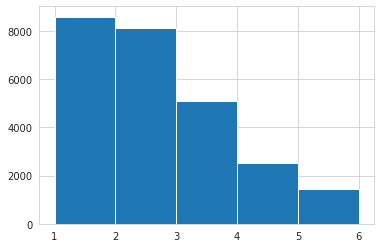

In [ ]:
#para cada año 
# df=ListOfYearCS[3]
df=CS2020
# Tabla con todos los ISSN Repetidos en un año (o ScopusSourceID sería más robusto o más rápido porque no tengo que ver en qué columna mirar) contar>1
#crear una columna para el count

# as index false es vital para que no cree una serie sino un dataframe donde pueda apuntar a las variables https://realpython.com/pandas-groupby/
ContarSourceId=df.groupby(['ScopusSourceID'], as_index=False).size()
ContarSourceId


plt.hist(ContarSourceId ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)

In [ ]:
# # Para convertir el indice de una tabla en una columna de un df
# s.index.name = 'Date'
# s.reset_index()

# # Pero no lo necesito porque uso "as index false" para que no cree una serie sino un dataframe donde pueda apuntar a las variables https://realpython.com/pandas-groupby/
# total=filtered_dates.groupby(['provincia_iso'], as_index=False).agg(sum)


In [ ]:
# en lugar de mostrar solo las filas cuyo count sea mayor que 1 y  buscar las filas con el ScopusSourceID	 >1  y borrar las filas de menos Percentile
# aprovecho la función keep="last" para  eliminar todas las filas con un valor repetido, menos la ultima
# Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.

#primero tengo que ordenar por ScopusSourceID  y por Percentile ascendente
dfOrdered=df.sort_values(['ScopusSourceID', 'Percentile'], ascending=True)
dfOrderedNoDup = dfOrdered.drop_duplicates(subset=['ScopusSourceID'], keep="last")


(array([25990.,     0.,     0.,     0.,     0.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

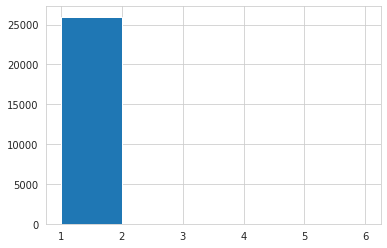

In [ ]:
# compruebo que ahora no hay ScopusSourceID repetidos
ContarSourceIdNoDup = dfOrderedNoDup.groupby("ScopusSourceID", as_index=False).size()
plt.hist(ContarSourceIdNoDup ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)

In [ ]:
#compruebo que me he quedado la fila con mejor percentil
print ("DataFrame with duplicates:"), print (ContarSourceId, "\n") 
print ("DataFrame without duplicates:"), print (ContarSourceIdNoDup, "\n")

dfOrdered.groupby("ScopusSourceID", as_index=False).mean()



DataFrame with duplicates:
       ScopusSourceID  size
0               12001     2
1               12002     2
2               12004     2
3               12005     2
4               12006     4
...               ...   ...
25985     21101041510     3
25986     21101041511     4
25987     21101041512     4
25988     21101041552     2
25989     21101041622     1

[25990 rows x 2 columns] 

DataFrame without duplicates:
       ScopusSourceID  size
0               12001     1
1               12002     1
2               12004     1
3               12005     1
4               12006     1
...               ...   ...
25985     21101041510     1
25986     21101041511     1
25987     21101041512     1
25988     21101041552     1
25989     21101041622     1

[25990 rows x 2 columns] 



,ScopusSourceID,CitationCount,ScholarlyOutput,PercentCited,ScopusASJCCode,Percentile,RANK,RankOutOf,Quartile
0,12001,774.0,247.0,74.0,3003.50,44.000000,59.00,113.000000,2.5
1,12002,58.0,63.0,43.0,2201.50,58.500000,110.00,690.500000,2.0
2,12004,517.0,151.0,73.0,2970.50,66.500000,134.50,392.500000,2.0
3,12005,1456.0,379.0,70.0,2970.50,70.500000,119.00,392.500000,1.5
4,12006,3253.0,385.0,87.0,2808.00,95.000000,11.75,449.500000,1.0
...,...,...,...,...,...,...,...,...,...
25985,21101041510,37.0,62.0,34.0,3049.00,15.666667,232.00,281.666667,4.0
25986,21101041511,29.0,88.0,27.0,2856.25,23.250000,18.25,24.250000,3.5
25987,21101041512,1.0,8.0,13.0,2721.00,6.000000,144.00,153.000000,4.0
25988,21101041552,779.0,245.0,80.0,2827.00,79.000000,46.00,159.000000,1.5


In [ ]:
dfOrderedNoDup.groupby("ScopusSourceID", as_index=False).mean()

,ScopusSourceID,CitationCount,ScholarlyOutput,PercentCited,ScopusASJCCode,Percentile,RANK,RankOutOf,Quartile
0,12001,774.0,247.0,74.0,3205.0,55.0,66.0,148.0,2.0
1,12002,58.0,63.0,43.0,1202.0,86.0,183.0,1328.0,1.0
2,12004,517.0,151.0,73.0,3203.0,71.0,81.0,283.0,2.0
3,12005,1456.0,379.0,70.0,3203.0,75.0,70.0,283.0,1.0
4,12006,3253.0,385.0,87.0,3304.0,98.0,17.0,1319.0,1.0
...,...,...,...,...,...,...,...,...,...
25985,21101041510,37.0,62.0,34.0,3203.0,21.0,224.0,283.0,4.0
25986,21101041511,29.0,88.0,27.0,2913.0,32.0,18.0,26.0,3.0
25987,21101041512,1.0,8.0,13.0,2715.0,12.0,120.0,136.0,4.0
25988,21101041552,779.0,245.0,80.0,2919.0,89.0,3.0,24.0,1.0


###Modelo con todos los años

In [ ]:
# replicar para todos los demás años

#pendiente MEJORA construir df con un bucle for i=2011 to 2020

In [ ]:
#mientras tengo un bucle lo hago manualemente
# Construir una tabla uniendo las filas de todos los años (Creando una columna de año CsYear)
df1=CS2020
df1['CsYear'] =2020

df2=CS2019
df2['CsYear'] =2019
df=df1.append(df2)

df3=CS2018
df3['CsYear'] =2018
df=df.append(df3)

df4=CS2017
df4['CsYear'] =2017
df=df.append(df4)

df5=CS2016
df5['CsYear'] =2016
df=df.append(df5)

df6=CS2015
df6['CsYear'] =2015
df=df.append(df6)

df7=CS2014
df7['CsYear'] =2014
df=df.append(df7)

df8=CS2013
df8['CsYear'] =2013
df=df.append(df8)

df9=CS2012
df9['CsYear'] =2012
df=df.append(df9)

df10=CS2011
df10['CsYear'] =2011
df=df.append(df10)



df




,ScopusSourceID,Title,CitationCount,ScholarlyOutput,PercentCited,CiteScore,SNIP,SJR,ScopusASJCCode,ScopusSubSubjectArea,Percentile,RANK,RankOutOf,Publisher,Type,OpenAccess,Quartile,Top10,URLScopusSourceID,PrintISSN,ElectISSN,CsYear
0,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,1213.0,Visual Arts and Performing Arts,6.0,466.0,532.0,Swedish Society for Eighteenth-Century Studies,j,YES,4.0,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN,2020
1,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,1202.0,History,3.0,1235.0,1328.0,Swedish Society for Eighteenth-Century Studies,j,YES,4.0,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN,2020
2,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,3316.0,Cultural Studies,2.0,986.0,1037.0,Swedish Society for Eighteenth-Century Studies,j,YES,4.0,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN,2020
3,21100404576,2D Materials,12778,920,90,"13,9","1,402","2,702",2210.0,Mechanical Engineering,97.0,14.0,596.0,Institute of Physics Publishing,j,NO,1.0,VERDADERO,https://www.scopus.com/sourceid/21100404576,NaN,20531583,2020
4,21100404576,2D Materials,12778,920,90,"13,9","1,402","2,702",2211.0,Mechanics of Materials,97.0,11.0,377.0,Institute of Physics Publishing,j,NO,1.0,VERDADERO,https://www.scopus.com/sourceid/21100404576,NaN,20531583,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44430,12085,American Archivist,99,85,"37,6","1,2","1,891","0,605",1201.0,Arts and Humanities (miscellaneous),46.0,141.0,264.0,Society of American Archivists,j,NO,3.0,FALSO,https://www.scopus.com/sourceid/12085,3609081,NaN,2011
44431,12216,Molecular Biology and Evolution,10939,1077,"89,7","10,2","1,854","4,257",1312.0,Molecular Biology,88.0,39.0,335.0,Oxford University Press,j,NO,1.0,FALSO,https://www.scopus.com/sourceid/12216,7374038,15371719,2011
44432,12216,Molecular Biology and Evolution,10939,1077,"89,7","10,2","1,854","4,257",1105.0,"Ecology, Evolution, Behavior and Systematics",97.0,12.0,478.0,Oxford University Press,j,NO,1.0,VERDADERO,https://www.scopus.com/sourceid/12216,7374038,15371719,2011
44433,12216,Molecular Biology and Evolution,10939,1077,"89,7","10,2","1,854","4,257",2700.0,General Medicine,94.0,177.0,3161.0,Oxford University Press,j,NO,1.0,VERDADERO,https://www.scopus.com/sourceid/12216,7374038,15371719,2011


In [ ]:
#guardo tabla de scopus para usar posterioremente

df.to_csv('Tab1ScopusJournalMetrics.csv',encoding='utf-8', index=False)  #tarda unos 5  segundos (descargar en local unos 200 segundos)

# Trasladado en V1 a ejecución cada vez (borrar cuando esté confirmado)

In [ ]:
ContarSourceId=df.groupby(['CsYear','ScopusSourceID'], as_index=False).size()
ContarSourceId
# plt.hist(ContarSourceId ["size"], bins=[1,2,3,4,5,6])

,CsYear,ScopusSourceID,size
0,2011,12001,2
1,2011,12002,2
2,2011,12004,2
3,2011,12005,2
4,2011,12006,4
...,...,...,...
231287,2020,21101041510,3
231288,2020,21101041511,4
231289,2020,21101041512,4
231290,2020,21101041552,2


(array([231292.,      0.,      0.,      0.,      0.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

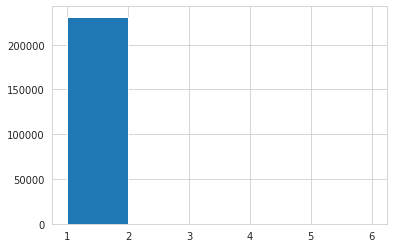

In [ ]:
# filtrar incluyendo repetición de CsYear ScopusSourceID

# en lugar de mostrar solo las filas cuyo count sea mayor que 1 y  buscar las filas con el ScopusSourceID	 >1  y borrar las filas de menos Percentile
# aprovecho la función keep="last" para  eliminar todas las filas con un valor repetido, menos la ultima
# Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.

#primero tengo que ordenar por CsYear ScopusSourceID  y por Percentile ascendente
dfOrdered=df.sort_values(['CsYear','ScopusSourceID', 'Percentile'], ascending=True)
dfOrderedNoDup = dfOrdered.drop_duplicates(subset=['CsYear','ScopusSourceID'], keep="last")
# compruebo que ahora no hay ScopusSourceID repetidos
ContarSourceIdNoDup = dfOrderedNoDup.groupby(['CsYear','ScopusSourceID'], as_index=False).size()
plt.hist(ContarSourceIdNoDup ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)

In [ ]:
#compruebo que me he quedado la fila con mejor percentil
print ("DataFrame with duplicates:"), print (ContarSourceId, "\n") 
print ("DataFrame without duplicates:"), print (ContarSourceIdNoDup, "\n")

dfOrdered.groupby(['CsYear','ScopusSourceID'], as_index=False).mean()

DataFrame with duplicates:
        CsYear  ScopusSourceID  size
0         2011           12001     2
1         2011           12002     2
2         2011           12004     2
3         2011           12005     2
4         2011           12006     4
...        ...             ...   ...
231287    2020     21101041510     3
231288    2020     21101041511     4
231289    2020     21101041512     4
231290    2020     21101041552     2
231291    2020     21101041622     1

[231292 rows x 3 columns] 

DataFrame without duplicates:
        CsYear  ScopusSourceID  size
0         2011           12001     1
1         2011           12002     1
2         2011           12004     1
3         2011           12005     1
4         2011           12006     1
...        ...             ...   ...
231287    2020     21101041510     1
231288    2020     21101041511     1
231289    2020     21101041512     1
231290    2020     21101041552     1
231291    2020     21101041622     1

[231292 rows x 3 columns]

,CsYear,ScopusSourceID,CitationCount,ScholarlyOutput,ScopusASJCCode,Percentile,RANK,RankOutOf,Quartile
0,2011,12001,344.0,197.0,3003.50,28.500000,59.00,82.000000,3.0
1,2011,12002,87.0,64.0,2201.50,66.500000,32.50,349.000000,2.0
2,2011,12004,185.0,118.0,2970.50,52.500000,163.00,337.500000,2.5
3,2011,12005,1881.0,385.0,2970.50,88.000000,42.50,337.500000,1.0
4,2011,12006,1591.0,342.0,2808.00,92.000000,14.00,280.500000,1.0
...,...,...,...,...,...,...,...,...,...
231287,2020,21101041510,37.0,62.0,3049.00,15.666667,232.00,281.666667,4.0
231288,2020,21101041511,29.0,88.0,2856.25,23.250000,18.25,24.250000,3.5
231289,2020,21101041512,1.0,8.0,2721.00,6.000000,144.00,153.000000,4.0
231290,2020,21101041552,779.0,245.0,2827.00,79.000000,46.00,159.000000,1.5


In [ ]:
dfOrderedNoDup.groupby(['CsYear','ScopusSourceID'], as_index=False).mean()

,CsYear,ScopusSourceID,CitationCount,ScholarlyOutput,ScopusASJCCode,Percentile,RANK,RankOutOf,Quartile
0,2011,12001,344.0,197.0,2802.0,29.0,38.0,53.0,3.0
1,2011,12002,87.0,64.0,1202.0,93.0,45.0,665.0,1.0
2,2011,12004,185.0,118.0,3203.0,57.0,99.0,233.0,2.0
3,2011,12005,1881.0,385.0,3203.0,92.0,18.0,233.0,1.0
4,2011,12006,1591.0,342.0,3304.0,96.0,25.0,787.0,1.0
...,...,...,...,...,...,...,...,...,...
231287,2020,21101041510,37.0,62.0,3203.0,21.0,224.0,283.0,4.0
231288,2020,21101041511,29.0,88.0,2913.0,32.0,18.0,26.0,3.0
231289,2020,21101041512,1.0,8.0,2715.0,12.0,120.0,136.0,4.0
231290,2020,21101041552,779.0,245.0,2919.0,89.0,3.0,24.0,1.0


In [ ]:
# dfOrderedNoDup.to_excel('dfOrderedNoDupScopus.xlsx') #tarda unos 150 segundos 

dfOrderedNoDup.to_csv('dfOrderedNoDupScopus.csv',encoding='utf-8', index=False)  #tarda unos 5  segundos (descargar en local unos 200 segundos)

# usar desde aquí para no repetir la carga de datos cada vez

In [ ]:
# Parte privada con ejemplos
# #prueba con Tab3DOIs(pruebameritos1096dois).csv
# !wget --output-document=Tab3DOIs.csv  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/gKnR_DdlTZyK24LBcNanxA

# # unas 1664 referencias descargadas como csv directametne de Scopus (el separador es ",")
# !wget --output-document=Tab4ScopusArticleMetrics.csv  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/LXftpYMDTPK04kJZQUk9tQ


# # Cargar la lisa de 616 articulos de WOS 
# # Exporto como excel los resultados		
# # 	XLS	
# # 	Se exportan de 1000 en mil	
# # 	Lo abro y guardo como XLSX)	
# # 		el xls de wos me da error en pandas
# !wget --output-document=Tab5WosArticleMetrics.csv  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/lgpTBHRxTHGkyIcCAqRiKA

In [2]:
# Parte Privada (recuperar de local)

#3861 filas articulos por DOI
!wget --output-document=Tab3DOIs.csv 


# metricas de articulos descargadas como csv directametne de Scopus (el separador es ",")
!wget --output-document=Tab4ScopusArticleMetrics.csv  


# metricas de articulos descargadas de wos como XLS abierta con excely guardadas como csv (el separador es ";")
!wget --output-document=Tab5WosArticleMetrics.csv  

#metricas de revistas scopus con las filas de TODOS los años y todas las categorias
!wget --output-document=Tab1ScopusJournalMetrics.csv  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/RuCYvT2HRXaXDezzFIxyJA

#  metrica de revista WOS por ISSN (ojo que hay que mirar en dos columnas, si no está en PrintISSN	 busco en ElectISSN
!wget --output-document=Tab2WosJournalMetrics.csv  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/Az_3JOOuRSuqF1Lp4VHFfw

--2022-03-04 18:03:48--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/0dleDuZtRhKm1XZKEDlfnA
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 14759259 (14M) [text/csv]
Saving to: ‘Tab3DOIs.csv’

Tab3DOIs.csv        100%[===================>]  14.08M  10.3MB/s    in 1.4s    

2022-03-04 18:03:50 (10.3 MB/s) - ‘Tab3DOIs.csv’ saved [14759259/14759259]

--2022-03-04 18:03:50--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/krigXfn2QFuq0rndIO43FQ
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 44539898 (42M) [text/csv]
Saving to: ‘Tab4ScopusArticleMetrics.csv’

Tab4ScopusArticleMe 100%[===================>]  42.48M  17.2MB/s    in 2.5s    

2022-03-04 18:03:53 (1

Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)
(array([3292.,  222.,   16.,    0.,    0.]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)
                          DOILimpio  size
812       10.1016/j.frl.2017.07.021     3
945    10.1016/j.intman.2015.03.005     3
960      10.1016/j.iref.2017.09.010     3
1027  10.1016/j.jbusres.2017.11.020     3
1102  10.1016/j.jclepro.2017.12.079     3
1481     10.1016/j.seps.2020.100928     3
1638      10.1016/j.wep.2019.02.006     3
1808  10.1080/03003930.2018.1560271     3
1929  10.1080/1331677X.2019.1696693     3
1936  10.1080/1331677X.2020.1833746     3
1999  10.1080/13683500.2019.1579174     3
2146       10.1108/BFJ-02-2019-0128     3
2153       10.1108/BFJ-12-2020-1156     3
2258     10.1108/IJWBR-06-2016-0017     3
2354       10.1108/OIR-05-2015-0155     3
2810    10.15240/tul/001/2016-4-008     3


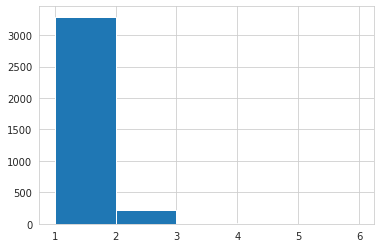

In [26]:
# Cargar la lista de referencias por DOIS 
# Algunos de ellos estarán solo en scopus, otros solo en WOS, otros en ambos y otros en ninguno

Tab3DOIs=pd.read_csv('Tab3DOIs.csv',sep=';')

# Actualziar la columna 'DOI' con 'DOI' si no es NaN e 'NaNserial' en caso contrario
## creo la base para una columna con valores unicos
df=None
df=Tab3DOIs.copy()
df['DOInew']='NaN'+ Tab3DOIs.index.astype(str)

## si DOI  tiene valor machaco en esa fila el valor de mixISSN
df.loc[df.DOI.notnull(),'DOInew']= df['DOILimpio']

Tab3DOIs['DOILimpio']=df['DOInew']

# MeritoDOI
# Comprobar que los duplicados en DOI (ver repetidos en diferentes solicitudes)
Contarduplicados = Tab3DOIs.groupby(['DOILimpio'], as_index=False).size()
print ("Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)")
print (plt.hist(Contarduplicados ["size"], bins=[1,2,3,4,5,6]))
print (Contarduplicados[Contarduplicados['size']==3])

Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)
(array([3.182e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)
Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)
(array([3183.,    0.,    0.,    0.,    0.]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)


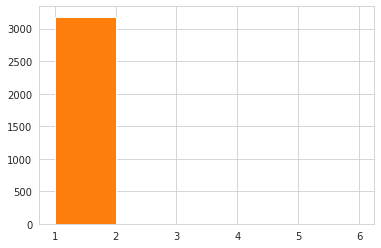

In [27]:
# Cargar la lista de articulos  de Scopus
Tab4ScopusArticleMetrics= pd.read_csv('Tab4ScopusArticleMetrics.csv',sep=',')

#filtro solo las columnas que me interesan para añadir información o cotejar que no hay errores en merge
# list(MeritosScopus)
ColumnScopus= ['Authors',
 'Author(s) ID',
 'Title',
 'Year',
 'Source title',
 'Page start',
 'Page end',
 'Page count',
 'Cited by',
 'DOI',
 'Abstract',
 'Author Keywords',
 'Index Keywords',
 'ISSN',
 'ISBN'
 ]
# ColumnScopus
Tab4ScopusArticleMetrics=Tab4ScopusArticleMetrics[ColumnScopus]

# MeritosScopus=MeritosScopus[['Authors',
#  'Author(s) ID',
#  'Title',
#  'Year',
#  'Source title',
#  'Page start',
#  'Page end',
#  'Page count',
#  'DOI',
#  'Abstract',
#  'Author Keywords',
#  'Index Keywords',
#  'Correspondence Address',
#  'ISSN',
#  'ISBN']]
# MeritosScopus
Tab4ScopusArticleMetrics.columns = 'sco_' + Tab4ScopusArticleMetrics.columns

# Comprobar que los duplicados en sco_DOI (como esto entra en parte derecha de un "merge" no debería haber duplicados)
Contarduplicados = Tab4ScopusArticleMetrics.groupby(['sco_DOI'], as_index=False).size()
print ("Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)")
print (plt.hist(Contarduplicados ["size"], bins=[1,2,3,4,5,6]))


### Hay un DOI repetido y tengo que revisarlo y cargarme la fila repetida
#busco uno a uno las filas de los ISSN problematicos
Tab4ScopusArticleMetrics.loc[Tab4ScopusArticleMetrics['sco_DOI']=='10.5547/01956574.39.SI1.scor']

#y los borro manualmente poniendo el numero del index de las filas a eliminar (no he anotado las primeras solo las ultimas)
Tab4ScopusArticleMetrics=Tab4ScopusArticleMetrics.drop(index=[1394])


# compruebo que ahora no hay ScopusSourceID repetidos
Contarduplicados = Tab4ScopusArticleMetrics.groupby(['sco_DOI'], as_index=False).size()
print ("Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)")
print (plt.hist(Contarduplicados ["size"], bins=[1,2,3,4,5,6]))

Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)
(array([3.122e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)
Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)
(array([3124.,    0.,    0.,    0.,    0.]), array([1, 2, 3, 4, 5, 6]), <a list of 5 Patch objects>)


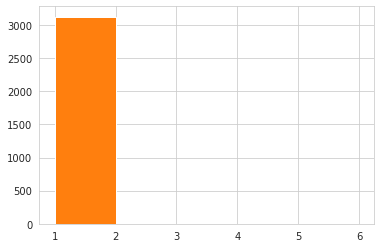

In [28]:
# # Cargar la lisa de articulos de WOS
# MeritosWos = pd.read_excel('Tab5WosArticleMetrics.xlsx', engine='openpyxl')

Tab5WosArticleMetrics= pd.read_csv('Tab5WosArticleMetrics.csv',sep=';')

#filtro solo las columnas que me interesan para añadir información o cotejar que no hay errores en merge
# list(MeritosWos)
ColumnWos= [ 'Authors',
  'Researcher Ids',
 'ORCIDs',
  'Article Title',
  'Source Title',
  'Start Page',
 'End Page',
  'DOI',
  'Publication Year',
 'Abstract',
  'Times Cited, WoS Core',
  'Times Cited, All Databases',
  'ISSN',
 'eISSN',
 'ISBN']
# ColumnWos
Tab5WosArticleMetrics=Tab5WosArticleMetrics[ColumnWos]
Tab5WosArticleMetrics.columns = 'wos_' + Tab5WosArticleMetrics.columns
# MeritosWos

###Mejora quitar este codigo si lo he conseguido resolver de otro modo (esto genera problemas en las revisas que Wos asigna percentil al electronico aunque haya de los dos)
# crear la columna 'mixISSN' con 'ISSN' si no es NaN e 'eISSN' en caso contrario
## creo la base para una columana con valores unicos
df=Tab5WosArticleMetrics.copy()
df['wos_art_mixISSN']='NaN'+ df.index.astype(str)

## si eISSN tiene valor machaco en esa fila el valor de mixISSN
df.loc[df.wos_eISSN.notnull(),'wos_art_mixISSN']= df['wos_eISSN']

df[['wos_art_mixISSN', 'wos_ISSN', 'wos_eISSN']]

## si ISSN tiene valor machaco en esa fila el valor de mixISSN
df.loc[df.wos_ISSN.notnull(),'wos_art_mixISSN']= df['wos_ISSN']
df[['wos_art_mixISSN', 'wos_ISSN', 'wos_eISSN']]

Tab5WosArticleMetrics['wos_art_mixISSN']=df['wos_art_mixISSN']

# Comprobar que los duplicados en wos_DOI (como esto entra en parte derecha de un "merge" no debería haber duplicados)
Contarduplicados = Tab5WosArticleMetrics.groupby(['wos_DOI'], as_index=False).size()
print ("Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)")
print (plt.hist(Contarduplicados ["size"], bins=[1,2,3,4,5,6]))

###ME quedé aquí
#busco uno a uo las filas de los ISSN problematicos
Tab5WosArticleMetrics[Tab5WosArticleMetrics['wos_DOI'].isin(['10.12706/itea.2020.031', '10.1371/journal.pone.0256182']) ]

#y los borro manualmente poniendo el numero del index de las filas a eliminar (no he anotado las primeras solo las ultimas)
Tab5WosArticleMetrics=Tab5WosArticleMetrics.drop(index=[75,239])


# compruebo que ahora no hay ScopusSourceID repetidos
Contarduplicados = Tab5WosArticleMetrics.groupby(['wos_DOI'], as_index=False).size()
print ("Histiograma de numero de DOI repetidos para articulos en la tabla3 (debe ser todo unos)")
print (plt.hist(Contarduplicados ["size"], bins=[1,2,3,4,5,6]))



In [29]:
# Añadir las columnas que me interesan de articulos de scopus a la tabla de DOIs 
#Todas las filas de DOIS de solicitudes se deben mantener si no está el DOI en Scopus la columna de esa fila se queda en blanco
###Mejora hay que asegurarse de que todas las filas de MeritoDOI tienen valor diferente en DOI, si no genera producto cartesiano... sustituir antes a mano por missing1..missingN
### mirar idea al final (es más sencillo añadir los perdidos con un merge de la tabla original que intentar que no se pierdan)
dfIntermedio=Tab3DOIs.merge(Tab4ScopusArticleMetrics, how='left', left_on='DOILimpio',right_on='sco_DOI' )
# dfIntermedio
### al integrarlo salen UNA fila más de las que tocan 3862, cunado MeritoDOI tiene 3861 Tengo que comprobar que no hay duplicados ni en DOI ni en Sco_DOI

# Añadir las columnas de articulos WOS a la lista de DOIS integrada con articulos de Scopus
dfIntermedio=dfIntermedio.merge(Tab5WosArticleMetrics, how='left', left_on='DOILimpio',right_on='wos_DOI' )
# dfIntermedio[['DOI','DOILimpio','sco_DOI', 'wos_DOI',   'sco_ISSN', 'wos_ISSN', 'wos_eISSN','wos_art_mixISSN']]

#  Integrar métricas de revistas Scopus a la tabla de méritos 


In [44]:
#cargar el archivo de revistas scopus con las filas de TODOS los años y todas las categorias
## OJO, pandas no reconoces la coma como separador de decimales por defecto (hay que ver cual es el que se usa en el archivo importado si he trabajado con sistema español)
Tab1ScopusJournalMetrics= pd.read_csv('Tab1ScopusJournalMetrics.csv',sep=',', decimal=',')
# Tab1ScopusJournalMetrics
# Tab1ScopusJournalMetrics.columns
# ['ScopusSourceID', 'Title', 'CitationCount', 'ScholarlyOutput',
#        'PercentCited', 'CiteScore', 'SNIP', 'SJR', 'ScopusASJCCode',
#        'ScopusSubSubjectArea', 'Percentile', 'RANK', 'RankOutOf', 'Publisher',
#        'Type', 'OpenAccess', 'Quartile', 'Top10', 'URLScopusSourceID',
#        'PrintISSN', 'ElectISSN', 'CsYear']

In [46]:
#pendiente Calcular el SJRpercent
Tab1ScopusJournalMetrics['SJRRank'] = Tab1ScopusJournalMetrics.groupby(['ScopusSubSubjectArea','CsYear'])['SJR'].rank(ascending=True, method='dense', na_option='keep')
Tab1ScopusJournalMetrics['SJRpercent'] = Tab1ScopusJournalMetrics.groupby(['ScopusSubSubjectArea','CsYear'])['SJR'].rank(ascending=True, method='dense', na_option='keep',pct=True)

exportTabl1=Tab1ScopusJournalMetrics[['ScopusSourceID', 'Title','PrintISSN', 'ElectISSN','ScopusSubSubjectArea','CsYear','SJR','SJRRank', 'SJRpercent']].copy()

# exportTabl1.to_csv('exportTabl1.csv',encoding='utf-8', index=False)

#pendiente calcular el BestCSPercentil y el BestSJRPercent

,ScopusSourceID,Title,PrintISSN,ElectISSN,ScopusSubSubjectArea,CsYear,SJR,SJRRank,SJRpercent
0,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,NaN,NaN,Visual Arts and Performing Arts,2020,0.000,1.0,0.006410
1,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,NaN,NaN,History,2020,0.000,1.0,0.003268
2,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,NaN,NaN,Cultural Studies,2020,0.000,1.0,0.002994
3,21100404576,2D Materials,NaN,20531583,Mechanical Engineering,2020,2.702,400.0,0.970874
4,21100404576,2D Materials,NaN,20531583,Mechanics of Materials,2020,2.702,291.0,0.966777
...,...,...,...,...,...,...,...,...,...
512647,12085,American Archivist,3609081,NaN,Arts and Humanities (miscellaneous),2011,0.605,118.0,0.495798
512648,12216,Molecular Biology and Evolution,7374038,15371719,Molecular Biology,2011,4.257,282.0,0.900958
512649,12216,Molecular Biology and Evolution,7374038,15371719,"Ecology, Evolution, Behavior and Systematics",2011,4.257,387.0,0.972362
512650,12216,Molecular Biology and Evolution,7374038,15371719,General Medicine,2011,4.257,1441.0,0.924310


In [23]:





#quedarme con la fila de mayor percentil CS de las diferentes categorias de cada año
ContarSourceId=Tab1ScopusJournalMetrics.groupby(['CsYear','ScopusSourceID'], as_index=False).size()
print ("Histiograma de numero de nmero de revistas con varios percentiles en el año")
print (plt.hist(ContarSourceId ["size"], bins=[1,2,3,4,5,6])),

# filtrar incluyendo repetición de CsYear ScopusSourceID

# en lugar de mostrar solo las filas cuyo count sea mayor que 1 y  buscar las filas con el ScopusSourceID	 >1  y borrar las filas de menos Percentile
# aprovecho la función keep="last" para  eliminar todas las filas con un valor repetido, menos la ultima
# Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.

#primero tengo que ordenar por CsYear ScopusSourceID  y por Percentile ascendente
dfOrdered=Tab1ScopusJournalMetrics.sort_values(['CsYear','ScopusSourceID', 'Percentile'], ascending=True)
dfOrderedNoDup = dfOrdered.drop_duplicates(subset=['CsYear','ScopusSourceID'], keep="last")
# compruebo que ahora no hay ScopusSourceID repetidos
ContarSourceIdNoDup = dfOrderedNoDup.groupby(['CsYear','ScopusSourceID'], as_index=False).size()
print ("Histiograma de numero de revistas con varios percentiles en el año tras quedarme con el mejor percentil (debe ser todo unos)")
print (plt.hist(ContarSourceIdNoDup ["size"], bins=[1,2,3,4,5,6]))
# plt.hist(ContarSourceId2 ["size"], bins=6)

#compruebo que me he quedado la fila con mejor percentil
print ("lista de numero ISSN por año with duplicates:"), print (ContarSourceId, "\n") 
print ("lista de numero ISSN por año tras eliminar duplicates:"), print (ContarSourceIdNoDup, "\n")

print ("DataFrame with duplicates:"),print (dfOrdered.groupby(['CsYear','ScopusSourceID'], as_index=False).mean())
print ("DataFrame without duplicates:"),print (dfOrderedNoDup.groupby(['CsYear','ScopusSourceID'], as_index=False).mean())


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['ScopusSourceID', 'Title', 'CitationCount', 'ScholarlyOutput',
       'PercentCited', 'CiteScore', 'SNIP', 'SJR', 'ScopusASJCCode',
       'ScopusSubSubjectArea', 'Percentile', 'RANK', 'RankOutOf', 'Publisher',
       'Type', 'OpenAccess', 'Quartile', 'Top10', 'URLScopusSourceID',
       'PrintISSN', 'ElectISSN', 'CsYear'],
      dtype='object')

In [ ]:
#  ENLAZAR tabla de meritos con metrica de revista SCOPUS por ISSN (ojo que hay que mirar en dos columnas, si no está en PrintISSN	 busco en ElectISSN
# Para el año de publicación del mérito
# esto no funciona porque los ISSN NaN crean un producto cartesiano--> dfIntermedioConScopus=dfIntermedio.merge(dfOrderedNoDupScopus, how='left', left_on='sco_ISSN',right_on='ElectISSN' )

#filtro las filas de dfIntermedio cuyo sco_ISSN sea distinto de NaN
###Mejora lo ideal sería en lugar de eso (que nos hace perder méritos), sustituir el valor NaN por un MisisingID (el numero de la fila) y asi no se pierde y se enlaza todo con NaNs en el merge
### mirar idea al final (es más sencillo añadir los perdidos con un merge de la tabla original que intentar que no se pierdan)

dfInterScoConISSN= dfIntermedio.loc[dfIntermedio.sco_ISSN.notnull()] #939 rows

## y dejo las columnas de metricas de revistas scopus que me interesan
# pendiente incluir BestPercent y BestSJR
dfOrderedNoDupScopusshort=dfOrderedNoDupScopus[['PrintISSN','CsYear','ScopusSubSubjectArea','Percentile','RANK','RankOutOf']]	
dfOrderedNoDupScopusshort.columns = 'sco_' + dfOrderedNoDupScopusshort.columns
# dfOrderedNoDupScopusshort


In [ ]:
# comprobar y resolver las filas duplicadas con mismo ISSN y año (no debería haber ninguna, pero las hay)

###Mejora Pendiente en dfOrderedNoDupScopus (el final del modulo que se ejecuta una vez. Ahora esta para usar con "short" pero hay que mejorar el csv)
##Resulta que hay algunos datos que tienen dos ISSN para cada año (pero eso ya lo habíamos eliminado...¿por qué? creo qeu son pocos casos 11 es decir UN ISSN repetido en los 11 años)
ScopusshortUniqueIssn= dfOrderedNoDupScopusshort.loc[dfOrderedNoDupScopusshort.sco_PrintISSN.notnull()] 
ContarScop = ScopusshortUniqueIssn.groupby(['sco_PrintISSN','sco_CsYear'], as_index=False).size()
ContarScop ["size"].unique()
pd.Index(ContarScop ["size"]).value_counts()
#las filas problemáticas
ContarScop.loc[ContarScop["size"]==2]
# 10628	10009345	2020	2
# 101144	17455057	2016	2
# 101145	17455057	2017	2
# 101146	17455057	2018	2
# 138627	214922	2011	2
# 138630	214922	2014	2
# 138631	214922	2015	2
# 138632	214922	2016	2
# 138633	214922	2017	2
# 142340	21903018	2017	2
# 142341	21903018	2018	2

www=dfOrderedNoDupScopusshort
#busco uno a uo las filas de los ISSN problematicos
dfOrderedNoDupScopusshort.loc[dfOrderedNoDupScopusshort['sco_PrintISSN']=='10009345']

#y los borro manualmente poniendo el numero del index de las filas a eliminar (no he anotado las primeras solo las ultimas)
www=www.drop(index=[226038])
www=www.drop(index=[123742, 74343, 167267])

www=www.drop(index=[9203, 143366, 96610, 119254, 142377])
www=www.drop(index=[153974, 177760 ])

www.loc[www['sco_PrintISSN']=='10009345']

# y ahora actualizo el dataframe que se queda como debería.
dfOrderedNoDupScopusshort=www
# #y compruebo
# ScopusshortUniqueIssn= dfOrderedNoDupScopusshort.loc[dfOrderedNoDupScopusshort.sco_PrintISSN.notnull()] 
# ContarScop = ScopusshortUniqueIssn.groupby(['sco_PrintISSN','sco_CsYear'], as_index=False).size()
# ContarScop ["size"].unique()
# pd.Index(ContarScop ["size"]).value_counts()
# #las filas problemáticas
# ContarScop.loc[ContarScop["size"]==2]


In [ ]:
# A las  filas de dfInterScoConISSN les añados las columnas de dfOrderedNoDupScopus para la fila donde sco_ISSN coincida con PrintISSN	 o con ElectISSN; y donde sco_Year coincida con CsYear
#en principio siempre debe existir la fila porque su el merito está en scopus, la revista debe estar en scopus
#si el año es menor que 2011, pongo datos de 2011 y si es mayor que 2020 pongo los de 2020

#### con print me coge muchos.. pero no todos... y con Elect creo que no me cogia ninguno PERO ES PORQUE TENGO muchos fuera de rango

dfIntermedioConScopus=dfInterScoConISSN.merge(dfOrderedNoDupScopusshort, how='left', left_on=['sco_ISSN', 'sco_Year'],right_on=['sco_PrintISSN','sco_CsYear'])
dfIntermedioConScopus.rename(columns={'sco_Percentile': 'sco_PercentileYearPub', 'sco_RANK': 'sco_RANKYearPub','sco_RankOutOf': 'sco_RankOutOfYearPub'}, inplace=True)
# dfIntermedioConScopus
dfIntermedioConScopus.to_csv('dfIntermedioConScopus.csv',encoding='utf-8', index=False)  #tarda unos 1  segundos (descargar en local unos 15 segundos)

In [ ]:
# Preparar un dataframe que tenga como index el ISSN y como columnas los percentiles de CS scopus de cada año (desde 2011 hasta 2020 de Citescore (serán también de color azul)

# Depricated
## dfOrderedNoDupScopusshort['sco_CsYear'].unique()
## for i in dfOrderedNoDupScopusshort['sco_CsYear'].unique():
##   print(i)

#tengo qeu quitar los que tengan el index del pivot (en mi caso prinISSN) como NaN
dfOrderedNoDupScopusshortConISSN= dfOrderedNoDupScopusshort.loc[dfOrderedNoDupScopusshort.sco_PrintISSN.notnull()] #222039 ( de 231281 rows)

pivotedScopus = dfOrderedNoDupScopusshortConISSN.pivot( index='sco_PrintISSN', columns="sco_CsYear", values="sco_Percentile")
pivotedScopus

# Renombrar header de columnas de pivoted para que sea "sco_percenYear"
pivotedScopus.dtypes
list(pivotedScopus)
pivotedScopus.columns = pivotedScopus.columns.astype(str)

pivotedScopus.columns = 'sco_percen' + pivotedScopus.columns

###Mejora pendiente 
# Hay lagunos print_issn de más de 8 cifras (parece que juntan el ISSNs)

# sco_CsYear	2011	2012	2013	2014	2015	2016	2017	2018	2019	2020
# sco_PrintISSN										
# 00014192 00341843	NaN	NaN	NaN	NaN	NaN	NaN	NaN	9.0	8.0	NaN
# 0001527X	62.0	54.0	52.0	54.0	55.0	50.0	52.0	52.0	53.0	52.0
# 00015512 17843286	NaN	NaN	NaN	NaN	NaN	NaN	NaN	68.0	74.0	NaN
# 0001625X	NaN	NaN	NaN	NaN	NaN	2.0	9.0	21.0	25.0	37.0
# 0001690X	92.0	95.0	97.0	97.0	97.0	96.0	96.0	95.0	95.0	95.0
# ...	...	...	...	...	...	...	...	...	...	...
# 997250	1.0	2.0	1.0	1.0	2.0	2.0	3.0	0.0	NaN	NaN
# 9977538	85.0	89.0	94.0	90.0	96.0	92.0	91.0	90.0	87.0	89.0
# 9977546	75.0	78.0	78.0	84.0	79.0	86.0	93.0	90.0	83.0	90.0
# 9977554	28.0	19.0	25.0	34.0	30.0	26.0	24.0	25.0	23.0	20.0
# 9997385	6.0	5.0	5.0	4.0	2.0	1.0	3.0	2.0	2.0	2.0

In [ ]:
# Añadir las columnas historicas (en la misma fila todos los años disponibles... solo la del percentil en scopus  para no tener varias por año)
# primero tengo que convertir en columnas los repetidos por años

dfIntermedioConScopus=dfIntermedioConScopus.merge(pivotedScopus, how='left', left_on=['sco_ISSN'],right_on=['sco_PrintISSN'])
dfIntermedioConScopus.to_csv('dfIntermedioConScopus.csv',encoding='utf-8', index=False)  #tarda unos 1  segundos (descargar en local unos 15 segundos)
# dfIntermedioConScopus

,DNISolicitante,Clave Solicitud,Tipo Convocatoria,Área,Cod Campo Científico,Tramo Largo,Clase Aportación,DOIaneca,DOI,Issn/Isbn,Año Publicación,Título continente,Título,Breve Resumen,Indicios Calidad,Codigo o nombre de evaluador-a,Puntos entregados al mérito,Observaciones,Convocatoria,sco_Authors,sco_Author(s) ID,sco_Title,sco_Year,sco_Source title,sco_Page start,sco_Page end,sco_Page count,sco_Cited by,sco_DOI,sco_Abstract,sco_Author Keywords,sco_Index Keywords,sco_ISSN,sco_ISBN,wos_Authors,wos_Researcher Ids,wos_ORCIDs,wos_Article Title,wos_Source Title,wos_Start Page,wos_End Page,wos_DOI,wos_Publication Year,wos_Abstract,"wos_Times Cited, WoS Core","wos_Times Cited, All Databases",wos_ISSN,wos_eISSN,wos_ISBN,wos_art_mixISSN,sco_PrintISSN,sco_CsYear,sco_ScopusSubSubjectArea,sco_PercentileYearPub,sco_RANKYearPub,sco_RankOutOfYearPub,sco_percen2011,sco_percen2012,sco_percen2013,sco_percen2014,sco_percen2015,sco_percen2016,sco_percen2017,sco_percen2018,sco_percen2019,sco_percen2020
0,76720310S,ACC#1155-667229,CONVENIO,ECONOMIA FINANCIERA Y CONTABILIDAD,8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21458,10.1002/agr.21458,1520-6297,2016,Agribusiness,Firm size and financial performance: Intermedi...,Este artículo pertenece a la línea de investig...,Agribusiness es una revista fundada en 1985 qu...,NaN,NaN,NaN,NaN,"Lopez-Valeiras E., Gomez-Conde J., Fernandez-R...",55022681300;55022680900;57191616816;,Firm Size and Financial Performance: Intermedi...,2016.0,Agribusiness,454,465,NaN,16.0,10.1002/agr.21458,This paper offers a new perspective for the ag...,NaN,NaN,7424477,NaN,"Lopez-Valeiras, Ernesto; Gomez-Conde, Jacobo; ...","Lopez-Valeiras, Ernesto/C-5760-2014; Gomez-Con...","Lopez-Valeiras, Ernesto/0000-0003-1576-7207; G...",Firm Size and Financial Performance: Intermedi...,AGRIBUSINESS,454,465,10.1002/agr.21458,2016.0,NaN,8.0,8.0,0742-4477,1520-6297,NaN,0742-4477,7424477,2016.0,"Geography, Planning and Development",72.0,165.0,606.0,71.0,69.0,71.0,65.0,71.0,72.0,70.0,76.0,76.0,73.0
1,23223320J,ACC#1155-673096,ORDINARIA,"ECONOMIA, SOCIOLOGIA Y POLITICA AGRARIA",8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21513,10.1002/agr.21513,0742-4477,2018,AGRIBUSINESS,Financial Behavior of cooperatives and investo...,Las cooperativas agroalimentarias son empresas...,REVISTA INDEXADA en JCR (Journal Citation Repo...,NaN,NaN,NaN,NaN,"Martínez-Victoria M., Arcas Lario N., Maté Sán...",57191543489;6505792699;35799775800;,Financial behavior of cooperatives and investo...,2018.0,Agribusiness,456,471,NaN,7.0,10.1002/agr.21513,A partial adjustment model was formulated to c...,NaN,NaN,7424477,NaN,"Martinez-Victoria, MCarmen; Arcas Lario, Narci...","Mate, Mariluz/H-2131-2015","Mate, Mariluz/0000-0002-9805-6365; Martinez-Vi...",Financial behavior of cooperatives and investo...,AGRIBUSINESS,456,471,10.1002/agr.21513,2018.0,NaN,6.0,6.0,0742-4477,1520-6297,NaN,0742-4477,7424477,2018.0,"Geography, Planning and Development",76.0,157.0,656.0,71.0,69.0,71.0,65.0,71.0,72.0,70.0,76.0,76.0,73.0
2,21989618P,ACC#1155-650287,ORDINARIA,COMERCIALIZACION E INVESTIGACION DE MERCADOS,8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21526,10.1002/agr.21526,0742-4477,2018,Agribusiness,"Firm reputation, advertising investment, and p...",La investigación ha reconocido que el precio d...,A. Índice de impacto: Este artículo ha sido pu...,NaN,NaN,NaN,NaN,"Sellers-Rubio R., Mas-Ruiz F., Sancho-Esper F.",12753427600;6507562565;57191193783;,"Firm reputation, advertising investment, and p...",2018.0,Agribusiness,351,362,NaN,3.0,10.1002/agr.21526,Research has recognized that the price of an e...,NaN,NaN,7424477,NaN,"Sellers-Rubio, Ricardo; Mas-Ruiz, Francisco; S...","MAS-RUIZ, FRANCISCO/H-4365-2015; Sellers-Rubio...","MAS-RUIZ, FRANCISCO/0000-0002-3342-012X; Selle...","Firm reputation, advertising investment, and p...",AGRIBUSINESS,351,362,10.1002/agr.21526,2018.0,NaN,3.0,3.0,0742-4477,1520-6297,NaN,0742-4477,7424477,2018.0,"Geography, Planning and Develo

#  Integrar métricas de revisas WOS a la tabla de méritos 
-no obstante, WOs tiene la "sorpresita" de que usa dos columnas de ISSN (la print y la Electronica). La mayoría de las revistas tienen print y con eso se enlazan bien. Pero hay algunas sin printISSN y hay que pillar la columna de e_ISSN. En cualquier caso son muy poquitas




In [ ]:
# Para cada año dejar solo la fila donde una revista tenga el mejor PErfecntil de JIF 
# (igual no es la fila con el mejor percentil de JCI)
# El JCI ya está normalizado (aunque es una media de medias) y puedo percentilizarlo para cada año/categoria porque están todos los datos

# Journal Citation Indicator se ha normalizado estableciendo 1 como la media de citas "promedio" a nivel mundial para la categoría.
#  Un valor superior a 1, por ejemplo un JCI = 1,45 supone que los artículos y revisiones de esa revista obtienen un 45% más de citas que las normales en esa categoría.
#   Si es menor de 1, obtienen un número de citas menor del esperado en esa categoría.
#[[como el JCI no está acotado por arriba -puede tener numeros como 4 etc... implica que la revisa puede tener en promedio un 400% más de citas el cuadruple de citas que la media de la categoria]]
# https://guiasbus.us.es/jcr/jci

# A journal with a JCI value = 1.0
# means that published papers, across the journal, received citations equal to the average (mean) for the category.


In [ ]:
#  ENLAZAR tabla de meritos con metrica de revista WOS por ISSN (ojo que hay que mirar en dos columnas, si no está en PrintISSN	 busco en ElectISSN
#primero tengo que cargar los datos de métricas de revistas
#  el rotulo de la primera pestaña (Que es la que realmente voy a importar). Los datos deben estar siempre en la misma pestaña. 
#  Si luego queréis mantener o añadir pestañas adicionales como referencia en el libro, no me afecta.
# los missings los he etiquetado con NaN, en el fondo phyton trabaja igual con n/a que con NaN, pero prefiero NaN porque es como me muestra por defecto los missings. 



## OJO, pandas no reconoces la coma como separador de decimales por defecto (hay que ver cual es el que se usa en el archivo importado si he trabajado con sistema español)
JournalMetricsWos =pd.read_csv('Tab2WosJournalMetrics.csv',sep=';', decimal=',') # 2 segundos # 24723 rows 2015-2020
JournalMetricsWos.columns = 'wos_' + JournalMetricsWos.columns
JournalMetricsWos.dtypes

list(JournalMetricsWos)
# ['wos_Fichero',
#  'wos_ID',
#  'wos_Year',
#  'wos_Areas',
#  'wos_Journal name',
#  'wos_ISSN',
#  'wos_eISSN',
#  'wos_Category',
#  'wos_Total Citations',
#  'wos_JIF',
#  'wos_JIF Quartile',
#  'wos_JCI',
#  'wos_% of OA Gold',
#  'wos_5 Year JIF',
#  'wos_JIF Without Self Cites',
#  'wos_Immediacy Index',
#  'wos_Eigenfactor',
#  'wos_Normalized Eigenfactor',
#  'wos_Article Influence Score',
#  'wos_JIF Percentile',
#  'wos_Citable Items',
#  'wos_Cited Half-Life',
#  'wos_% of Articles in Citable items',
#  'wos_Citing Half-Life',
#  'wos_Total Articles']

#convertir en numero lo que es numero (y que no sea object)
#ya no es necesario si he usado el adecuado separador decimal para leer el csv

# JournalMetricsWos[[ 'wos_Total Citations',
#  'wos_JIF',
#  'wos_JCI',
#  'wos_% of OA Gold',
#  'wos_5 Year JIF',
#  'wos_JIF Without Self Cites',
#  'wos_Immediacy Index',
#  'wos_Eigenfactor',
#  'wos_Normalized Eigenfactor',
#  'wos_Article Influence Score',
#  'wos_JIF Percentile',
#  'wos_Citable Items',
#  'wos_Cited Half-Life',
#  'wos_% of Articles in Citable items',
#  'wos_Citing Half-Life',
#  'wos_Total Articles']]= JournalMetricsWos[['wos_Total Citations',
#  'wos_JIF',
#  'wos_JCI',
#  'wos_% of OA Gold',
#  'wos_5 Year JIF',
#  'wos_JIF Without Self Cites',
#  'wos_Immediacy Index',
#  'wos_Eigenfactor',
#  'wos_Normalized Eigenfactor',
#  'wos_Article Influence Score',
#  'wos_JIF Percentile',
#  'wos_Citable Items',
#  'wos_Cited Half-Life',
#  'wos_% of Articles in Citable items',
#  'wos_Citing Half-Life',
#  'wos_Total Articles']].apply(pd.to_numeric, axis=1)




--2022-02-28 12:41:13--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/Az_3JOOuRSuqF1Lp4VHFfw
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 10154064 (9.7M) [text/csv]
Saving to: ‘JournalMetricsWos.csv’

JournalMetricsWos.c 100%[===================>]   9.68M  6.04MB/s    in 1.6s    

2022-02-28 12:41:15 (6.04 MB/s) - ‘JournalMetricsWos.csv’ saved [10154064/10154064]



['wos_Fichero',
 'wos_ID',
 'wos_Year',
 'wos_Areas',
 'wos_Journal name',
 'wos_ISSN',
 'wos_eISSN',
 'wos_Category',
 'wos_Total Citations',
 'wos_JIF',
 'wos_JIF Quartile',
 'wos_JCI',
 'wos_Immediacy Index',
 'wos_JIF Without Self Cites',
 'wos_5 Year JIF',
 'wos_Eigenfactor',
 'wos_Normalized Eigenfactor',
 'wos_Article Influence Score',
 'wos_JIF Percentile',
 'wos_Total Articles',
 'wos_% of OA Gold',
 'wos_Citing Half-Life',
 'wos_Cited Half-Life',
 'wos_% of Articles in Citable items',
 'wos_Citable Items']

In [ ]:
### APARCADO
#calcular una columna de percentil JCI (aunque no creo que "sirva de verdad" porque el JCI ya está normalizado)
# puedo comprobar que un JCI de 1 -que representa "lo normal, el promedio" es equivalente al percentil 50
#no será exacto porque el JCI promedia los CNCI de los articulos por categoria y año, luego todos los años y luego todas las categorias de las revistas
# lo que se presenta separado por categorias es el PERCENTIL. PEro el JCI ya es un agregado de las distintas categorias (y solo hay uno por revista) 
# hacer un percentil de algo que ya está normalizado (referido a la media me parece un poco absurdo)



JournalMetricsWos['wos_JCIpercentil'] = JournalMetricsWos.groupby(['Year','Category'])['JCI'].transform(lambda x: x.quantile(.11))
JournalMetricsWos.to_csv('JournalMetricsWosConPERCEntJCI.csv',encoding='utf-8', index=False) 
#no sale un percentile.. sino que salen unos numeros "raros"
#lo calculo a mano, con la formula del percentil pero hay que hacer el rango por grupos de año y categoria, con eso sale todo
#puedo intentarlo con una instrucción
sz = temp['INCOME'].size-1
temp['PCNT_LIN'] = temp['INCOME'].rank(method='max').apply(lambda x: 100.0*(x-1)/sz)

# o puedo crear una columna para el rango  otra para Out Of (que es el ranks.max) en cada categoria
ranks = num.rank()
(ranks - ranks.min())/(ranks.max() - ranks.min())

In [ ]:
###mejora calcular a mano wos_JIF_Rank y wos_Rankout
# El numero de revisas de la categoria es el mismo para JIF que para JCI, pero el rango no
# me lo dejo preparado con las columans con missings para que esté en el codigo y las calculo cuando toque

JournalMetricsWos[['wos_JIF_Rank','wos_JCI_Rank','wos_Rankout','wos_JCIpercentil']]=np.NaN

DataFrame with duplicates:
       wos_Year wos_mixISSN  size
0          2011   0001-2491     1
1          2011   0001-253X     2
2          2011   0001-3072     1
3          2011   0001-4273     2
4          2011   0001-4575     2
...         ...         ...   ...
32309      2020   8756-5641     1
32310      2020   8756-6222     1
32311      2020   8756-758X     1
32312      2020   8756-8225     1
32313      2020   8756-9728     1

[32314 rows x 3 columns] 

DataFrame without duplicates:
       wos_Year wos_mixISSN  size
0          2011   0001-2491     1
1          2011   0001-253X     1
2          2011   0001-3072     1
3          2011   0001-4273     1
4          2011   0001-4575     1
...         ...         ...   ...
32309      2020   8756-5641     1
32310      2020   8756-6222     1
32311      2020   8756-758X     1
32312      2020   8756-8225     1
32313      2020   8756-9728     1

[32314 rows x 3 columns] 



,wos_Year,wos_mixISSN,wos_ID,wos_Total Citations,wos_JIF,wos_JCI,wos_Immediacy Index,wos_JIF Without Self Cites,wos_5 Year JIF,wos_Eigenfactor,wos_Normalized Eigenfactor,wos_Article Influence Score,wos_JIF Percentile,wos_Total Articles,wos_% of OA Gold,wos_% of Articles in Citable items,wos_Citable Items,wos_JIF_Rank,wos_JCI_Rank,wos_Rankout,wos_JCIpercentil
0,2011,0001-2491,39113.0,390.0,0.392,NaN,0.010,0.348,0.363,0.001,NaN,0.103,20.080,101.0,NaN,1.0000,101.0,NaN,NaN,NaN,NaN
1,2011,0001-253X,30237.0,256.0,0.635,NaN,0.056,0.568,0.699,0.001,NaN,0.273,39.535,36.0,NaN,1.0000,36.0,NaN,NaN,NaN,NaN
2,2011,0001-3072,30079.0,282.0,0.860,NaN,0.050,0.674,0.960,0.001,NaN,0.290,51.740,20.0,NaN,1.0000,20.0,NaN,NaN,NaN,NaN
3,2011,0001-4273,32570.0,17848.0,5.608,NaN,0.648,5.342,10.565,0.031,NaN,5.630,98.890,53.0,NaN,0.9815,54.0,NaN,NaN,NaN,NaN
4,2011,0001-4575,33895.5,5730.0,1.867,NaN,0.390,1.326,2.367,0.014,NaN,0.773,83.205,261.0,NaN,0.9886,264.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32309,2020,8756-5641,21555.0,3570.0,2.253,0.56,0.278,2.181,2.945,0.002,0.353,0.899,37.010,35.0,0.0420,0.9722,36.0,NaN,NaN,NaN,NaN
32310,2020,8756-6222,6960.0,2784.0,2.075,1.22,0.417,2.050,2.151,0.003,0.586,2.283,54.120,12.0,0.0577,1.0000,12.0,NaN,NaN,NaN,NaN
32311,2020,8756-758X,24271.0,6488.0,3.459,0.88,0.964,2.693,3.062,0.005,0.985,0.564,72.560,275.0,0.0601,0.9786,281.0,NaN,NaN,NaN,NaN
32312,2020,8756-8225,22214.0,400.0,NaN,0.26,0.320,NaN,NaN,0.000,0.068,0.290,NaN,50.0,0.0110,1.0000,50.0,NaN,NaN,NaN,NaN


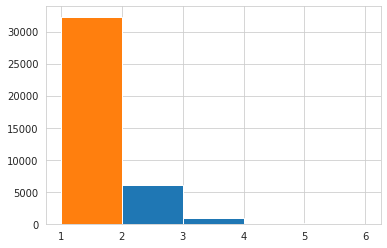

In [ ]:
#  'wos_ID',
#  'wos_Year',
#  'wos_Areas',
#  'wos_Journal name',
#  'wos_ISSN',
#  'wos_eISSN',
#  'wos_Category',
 
#ver el numero de missings en 'ISSN' y en  'eISSN',
df=JournalMetricsWos.copy() #24723 rows

dfMissingISSN= df.loc[df.wos_ISSN.notnull()] #24568 rows 155 missings(comprobados con excel)

dfMissingeISSN= df.loc[df.wos_eISSN.notnull()] #23669 rows 1054 missings (comprobados con excel)

# crear la columna 'mixISSN' con 'ISSN' si no es NaN e 'eISSN' en caso contrario
## creo la base para una columana con valores unicos
df['wos_mixISSN']='NaN'+ df['wos_ID'].astype(str)
## si eISSN tiene valor machaco en esa fila el valor de mixISSN
df.loc[df.wos_eISSN.notnull(),'wos_mixISSN']= df['wos_eISSN']

df[['wos_mixISSN', 'wos_ISSN', 'wos_eISSN']]

## si ISSN tiene valor machaco en esa fila el valor de mixISSN
df.loc[df.wos_ISSN.notnull(),'wos_mixISSN']= df['wos_ISSN']
df[['wos_mixISSN', 'wos_ISSN', 'wos_eISSN']]

dfMissingMixISSN= df.loc[df.wos_mixISSN.notnull()] #24723 rows

######todas las filas tienen algun valor de MixISSN

#  Comprobar cuantos duplicados de misma revista y año (en distintas categorias) y convertir en no duplicados
# as index false es vital para que no cree una serie sino un dataframe donde pueda apuntar a las variables https://realpython.com/pandas-groupby/

ContarSourceId=df.groupby(['wos_Year','wos_mixISSN'], as_index=False).size()
ContarSourceId
# plt.hist(ContarSourceId ["size"], bins=[1,2,3,4,5,6])

plt.hist(ContarSourceId ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)


# filtrar incluyendo repetición de 'wos_Year','wos_mixISSN'

# en lugar de mostrar solo las filas cuyo count sea mayor que 1 y  buscar las filas con el wos_mixISSN	 >1  y borrar las filas de menos Percentile
# aprovecho la función keep="last" para  eliminar todas las filas con un valor repetido, menos la ultima
# Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.

#primero tengo que ordenar por wos_Year wos_mixISSN  y por Percentile ascendente

dfOrderedwos=df.sort_values(['wos_Year','wos_mixISSN','wos_JIF Percentile'], ascending=True)
dfOrderedNoDupwos = dfOrderedwos.drop_duplicates(subset=['wos_Year','wos_mixISSN'], keep="last")
# compruebo que ahora no hay ScopusSourceID repetidos
ContarSourceIdNoDup = dfOrderedNoDupwos.groupby(['wos_Year','wos_mixISSN'], as_index=False).size()
plt.hist(ContarSourceIdNoDup ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)



#compruebo que me he quedado la fila con mejor percentil
print ("DataFrame with duplicates:"), print (ContarSourceId, "\n") 
print ("DataFrame without duplicates:"), print (ContarSourceIdNoDup, "\n")

dfOrderedwos.groupby(['wos_Year','wos_mixISSN'], as_index=False).mean()


In [ ]:
#completar la comprobación anterior
dfOrderedNoDupwos.groupby(['wos_Year','wos_mixISSN'], as_index=False).mean()

,wos_Year,wos_mixISSN,wos_ID,wos_Total Citations,wos_JIF,wos_JCI,wos_Immediacy Index,wos_JIF Without Self Cites,wos_5 Year JIF,wos_Eigenfactor,wos_Normalized Eigenfactor,wos_Article Influence Score,wos_JIF Percentile,wos_Total Articles,wos_% of OA Gold,wos_% of Articles in Citable items,wos_Citable Items,wos_JIF_Rank,wos_JCI_Rank,wos_Rankout,wos_JCIpercentil
0,2011,0001-2491,39113.0,390.0,0.392,NaN,0.010,0.348,0.363,0.001,NaN,0.103,20.08,101.0,NaN,1.0000,101.0,NaN,NaN,NaN,NaN
1,2011,0001-253X,28950.0,256.0,0.635,NaN,0.056,0.568,0.699,0.001,NaN,0.273,47.59,36.0,NaN,1.0000,36.0,NaN,NaN,NaN,NaN
2,2011,0001-3072,30079.0,282.0,0.860,NaN,0.050,0.674,0.960,0.001,NaN,0.290,51.74,20.0,NaN,1.0000,20.0,NaN,NaN,NaN,NaN
3,2011,0001-4273,35281.0,17848.0,5.608,NaN,0.648,5.342,10.565,0.031,NaN,5.630,99.11,53.0,NaN,0.9815,54.0,NaN,NaN,NaN,NaN
4,2011,0001-4575,31257.0,5730.0,1.867,NaN,0.390,1.326,2.367,0.014,NaN,0.773,89.33,261.0,NaN,0.9886,264.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32309,2020,8756-5641,21555.0,3570.0,2.253,0.56,0.278,2.181,2.945,0.002,0.353,0.899,37.01,35.0,0.0420,0.9722,36.0,NaN,NaN,NaN,NaN
32310,2020,8756-6222,6960.0,2784.0,2.075,1.22,0.417,2.050,2.151,0.003,0.586,2.283,54.12,12.0,0.0577,1.0000,12.0,NaN,NaN,NaN,NaN
32311,2020,8756-758X,24271.0,6488.0,3.459,0.88,0.964,2.693,3.062,0.005,0.985,0.564,72.56,275.0,0.0601,0.9786,281.0,NaN,NaN,NaN,NaN
32312,2020,8756-8225,22214.0,400.0,NaN,0.26,0.320,NaN,NaN,0.000,0.068,0.290,NaN,50.0,0.0110,1.0000,50.0,NaN,NaN,NaN,NaN


In [ ]:
#Dejarlo como un archivo fijo para almacenar tal cual y repuperar o descargar si lo preciso
dfOrderedNoDupwos.to_csv('dfOrderedNoDupWOS.csv',encoding='utf-8', index=False)  #tarda unos 5  segundos (descargar en local unos 200 segundos)



In [ ]:
## y dejo las columnas de metricas de revistas scopwos us que me interesan integrar en el archivo final
list(dfOrderedNoDupwos)

dfOrderedNoDupwosshort=dfOrderedNoDupwos[[ 'wos_Year',
 'wos_Journal name',
 'wos_ISSN',
 'wos_eISSN',
 'wos_Category',
 'wos_JIF',
 'wos_JIF Percentile',
 'wos_JIF Quartile',
 'wos_JCI',
 'wos_mixISSN',
 'wos_JIF_Rank',
 'wos_JCI_Rank',
 'wos_Rankout',
 'wos_JCIpercentil']]	
# dfOrderedNoDupwosshort





In [ ]:

# Si fuese necesario comprobar y resolver filas duplicadas

# comprobar y resolver las filas duplicadas con mismo ISSN y año (no debería haber ninguna, pero las hay)

###Mejora Pendiente en dfOrderedNoDupScopus (el final del modulo que se ejecuta una vez. Ahora esta para usar con "short" pero hay que mejorar el csv)
##Resulta que hay algunos datos que tienen dos ISSN para cada año (pero eso ya lo habíamos eliminado...¿por qué? creo qeu son pocos casos 11 es decir UN ISSN repetido en los 11 años)
WOSshortUniqueIssn= dfOrderedNoDupwosshort.loc[dfOrderedNoDupwosshort.wos_mixISSN.notnull()] 
ContarWos = WOSshortUniqueIssn.groupby(['wos_mixISSN','wos_Year'], as_index=False).size()
ContarWos ["size"].unique()
pd.Index(ContarWos ["size"]).value_counts()
#las filas problemáticas
ContarWos.loc[ContarWos["size"]>1]
# no hay ninguno duplicado y no necesito ejecutar el resto de código (lo convierto en comment)

# www=dfOrderedNoDupwosshort
# #busco uno a uo las filas de los ISSN problematicos
# dfOrderedNoDupwosshort.loc[dfOrderedNoDupwosshort['wos_mixISSN']=='17455057']

# #y los borro manualmente poniendo el numero del index de las filas a eliminar (no he anotado las primeras solo las ultimas)
# www=www.drop(index=[226038])
# www=www.drop(index=[123742, 74343, 167267])

# www=www.drop(index=[9203, 143366, 96610, 119254, 142377])
# www=www.drop(index=[153974, 177760 ])

# www.loc[www['sco_PrintISSN']=='10009345']

# # y ahora actualizo el dataframe que se queda como debería.
# dfOrderedNoDupwosshort=www
# #y compruebo
# ScopusshortUniqueIssn= dfOrderedNoDupScopusshort.loc[dfOrderedNoDupScopusshort.sco_PrintISSN.notnull()] 
# ContarScop = ScopusshortUniqueIssn.groupby(['sco_PrintISSN','sco_CsYear'], as_index=False).size()
# ContarScop ["size"].unique()
# pd.Index(ContarScop ["size"]).value_counts()
# #las filas problemáticas
# ContarScop.loc[ContarScop["size"]==2]



,wos_mixISSN,wos_Year,size


In [ ]:
#  ENLAZAR tabla de meritos con metrica de revista wos por wos_mixISSN 
# Para el año de publicación del mérito
# Si los ISSN son NaN crean un producto cartesiano

# En WOS ya he aplicado la Mejora que nos hace perder méritos), sustituir el valor NaN por un MisisingID (el numero de la fila) y asi no se pierde y se enlaza todo con NaNs en el merge


# A las  filas de dfIntermedioConScopus les añados las columnas de dfOrderedNoDupwosshort para la fila donde wos_ISSN coincida con wos_mixISSN
# y donde sco_Year coincida con CsYear

#en principio siempre debe existir la fila porque si el merito está en WOS, la revista debe estar en InCites
# Hay que tener cuidado con los typos, de las claves de merge deben ser exacamente el mismo tipo (no basta que sea el mismo valor)

dfIntermedioConScopus[['wos_ISSN', 'wos_Publication Year']].dtypes
dfOrderedNoDupwosshort[['wos_mixISSN','wos_Year']].dtypes

dfIntermedioConScopus['wos_Publication Year']=dfIntermedioConScopus['wos_Publication Year'].astype(float)
dfOrderedNoDupwosshort['wos_Year']=dfOrderedNoDupwosshort['wos_Year'].astype(float)

# dfFinalConScopusWOS=dfIntermedioConScopus.merge(dfOrderedNoDupwosshort, how='left', left_on=['wos_ISSN', 'wos_Publication Year'],right_on=['wos_mixISSN','wos_Year'])
#mejorado poneiendo wos_art_mixISSN en meritos articulo wos para integrar printissn y eissn
dfFinalConScopusWOS=dfIntermedioConScopus.merge(dfOrderedNoDupwosshort, how='left', left_on=['wos_art_mixISSN', 'wos_Publication Year'],right_on=['wos_mixISSN','wos_Year'])



# list(dfIntermedioConScopus)
# ['DOI',
#  'DNISolicitante',
#  'sco_Authors',
#  'sco_Author(s) ID',
#  'sco_Title',
#  'sco_Year',
#  'sco_Source title',
#  'sco_Page start',
#  'sco_Page end',
#  'sco_Page count',
#  'sco_Cited by',
#  'sco_DOI',
#  'sco_Abstract',
#  'sco_Author Keywords',
#  'sco_Index Keywords',
#  'sco_ISSN',
#  'sco_ISBN',
#  'wos_Authors',
#  'wos_Researcher Ids',
#  'wos_ORCIDs',
#  'wos_Article Title',
#  'wos_Source Title',
#  'wos_Start Page',
#  'wos_End Page',
#  'wos_DOI',
#  'wos_Publication Year',
#  'wos_Abstract',
#  'wos_Times Cited, WoS Core',
#  'wos_Times Cited, All Databases',
#  'wos_ISSN',
#  'wos_eISSN',
#  'wos_ISBN',
#  'sco_PrintISSN',
#  'sco_CsYear',
#  'sco_ScopusSubSubjectArea',
#  'sco_PercentileYearPub',
#  'sco_RANKYearPub',
#  'sco_RankOutOfYearPub',
#  'sco_percen2011',
#  'sco_percen2012',
#  'sco_percen2013',
#  'sco_percen2014',
#  'sco_percen2015',
#  'sco_percen2016',
#  'sco_percen2017',
#  'sco_percen2018',
#  'sco_percen2019',
#  'sco_percen2020']
# list(dfOrderedNoDupwosshort)

# ['wos_Year',
#  'wos_Journal name',
#  'wos_ISSN',
#  'wos_eISSN',
#  'wos_Category',
#  'wos_JIF',
#  'wos_JIF Percentile',
#  'wos_JIF Quartile',
#  'wos_JCI',
#  'wos_mixISSN',
#  'wos_JIF_Rank',
#  'wos_JCI_Rank',
#  'wos_Rankout',
#  'wos_JCIpercentil']


dfFinalConScopusWOS.rename(columns={'wos_JIF Percentile': 'wos_JIF_PercentileYearPub','wos_JCI':'wos_JCIYearPub', 'wos_JIF_Rank': 'wos_JIF_RankYearPub'
,'wos_Rankout': 'wos_RankoutYearPub','wos_JCI_Rank': 'wos_JCI_RankPub'}, inplace=True)
dfFinalConScopusWOS




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,DNISolicitante,Clave Solicitud,Tipo Convocatoria,Área,Cod Campo Científico,Tramo Largo,Clase Aportación,DOIaneca,DOI,Issn/Isbn,Año Publicación,Título continente,Título,Breve Resumen,Indicios Calidad,Codigo o nombre de evaluador-a,Puntos entregados al mérito,Observaciones,Convocatoria,sco_Authors,sco_Author(s) ID,sco_Title,sco_Year,sco_Source title,sco_Page start,sco_Page end,sco_Page count,sco_Cited by,sco_DOI,sco_Abstract,sco_Author Keywords,sco_Index Keywords,sco_ISSN,sco_ISBN,wos_Authors,wos_Researcher Ids,wos_ORCIDs,wos_Article Title,wos_Source Title,wos_Start Page,wos_End Page,wos_DOI,wos_Publication Year,wos_Abstract,"wos_Times Cited, WoS Core","wos_Times Cited, All Databases",wos_ISSN_x,wos_eISSN_x,wos_ISBN,wos_art_mixISSN,sco_PrintISSN,sco_CsYear,sco_ScopusSubSubjectArea,sco_PercentileYearPub,sco_RANKYearPub,sco_RankOutOfYearPub,sco_percen2011,sco_percen2012,sco_percen2013,sco_percen2014,sco_percen2015,sco_percen2016,sco_percen2017,sco_percen2018,sco_percen2019,sco_percen2020,wos_Year,wos_Journal name,wos_ISSN_y,wos_eISSN_y,wos_Category,wos_JIF,wos_JIF_PercentileYearPub,wos_JIF Quartile,wos_JCIYearPub,wos_mixISSN,wos_JIF_RankYearPub,wos_JCI_RankPub,wos_RankoutYearPub,wos_JCIpercentil
0,76720310S,ACC#1155-667229,CONVENIO,ECONOMIA FINANCIERA Y CONTABILIDAD,8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21458,10.1002/agr.21458,1520-6297,2016,Agribusiness,Firm size and financial performance: Intermedi...,Este artículo pertenece a la línea de investig...,Agribusiness es una revista fundada en 1985 qu...,NaN,NaN,NaN,NaN,"Lopez-Valeiras E., Gomez-Conde J., Fernandez-R...",55022681300;55022680900;57191616816;,Firm Size and Financial Performance: Intermedi...,2016.0,Agribusiness,454,465,NaN,16.0,10.1002/agr.21458,This paper offers a new perspective for the ag...,NaN,NaN,7424477,NaN,"Lopez-Valeiras, Ernesto; Gomez-Conde, Jacobo; ...","Lopez-Valeiras, Ernesto/C-5760-2014; Gomez-Con...","Lopez-Valeiras, Ernesto/0000-0003-1576-7207; G...",Firm Size and Financial Performance: Intermedi...,AGRIBUSINESS,454,465,10.1002/agr.21458,2016.0,NaN,8.0,8.0,0742-4477,1520-6297,NaN,0742-4477,7424477,2016.0,"Geography, Planning and Development",72.0,165.0,606.0,71.0,69.0,71.0,65.0,71.0,72.0,70.0,76.0,76.0,73.0,2016.0,Agribusiness,0742-4477,1520-6297,ECONOMICS - SSCI,0.939,51.15,Q2,NaN,0742-4477,NaN,NaN,NaN,NaN
1,23223320J,ACC#1155-673096,ORDINARIA,"ECONOMIA, SOCIOLOGIA Y POLITICA AGRARIA",8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21513,10.1002/agr.21513,0742-4477,2018,AGRIBUSINESS,Financial Behavior of cooperatives and investo...,Las cooperativas agroalimentarias son empresas...,REVISTA INDEXADA en JCR (Journal Citation Repo...,NaN,NaN,NaN,NaN,"Martínez-Victoria M., Arcas Lario N., Maté Sán...",57191543489;6505792699;35799775800;,Financial behavior of cooperatives and investo...,2018.0,Agribusiness,456,471,NaN,7.0,10.1002/agr.21513,A partial adjustment model was formulated to c...,NaN,NaN,7424477,NaN,"Martinez-Victoria, MCarmen; Arcas Lario, Narci...","Mate, Mariluz/H-2131-2015","Mate, Mariluz/0000-0002-9805-6365; Martinez-Vi...",Financial behavior of cooperatives and investo...,AGRIBUSINESS,456,471,10.1002/agr.21513,2018.0,NaN,6.0,6.0,0742-4477,1520-6297,NaN,0742-4477,7424477,2018.0,"Geography, Planning and Development",76.0,157.0,656.0,71.0,69.0,71.0,65.0,71.0,72.0,70.0,76.0,76.0,73.0,2018.0,Agribusiness,0742-4477,1520-6297,ECONOMICS - SSCI,1.635,63.22,Q2,0.89,0742-4477,NaN,NaN,NaN,NaN
2,21989618P,ACC#1155-650287,ORDINARIA,COMERCIALIZACION E INVESTIGACION DE MERCADOS,8,2016 - 2017 - 2018 - 2019 - 2020 - 2021,A,10.1002/agr.21526,10.1002/agr.21526,0742-4477,2018,Agribusiness,"Firm reputation, advertising investment, and p...",La investigación ha reconocido que el precio d...,A. Índice de impacto: Este artículo ha sido pu...,NaN,NaN,NaN,NaN,"Sellers-Rubio R., Mas-Ruiz F., Sancho-Esper F.",12753427600;6507562565;57191193783;,"Firm reputation, advertising investment, and p...",2018.0,Agribusiness,351,362,NaN,3.0,10.1002/agr.2

In [ ]:

# Preparar un dataframe que tenga como index el ISSN y como columnas los percentiles de JIF y valor de JCI  de cada año (desde 2011 hasta 2020 de Citescore (serán también de color azul)

# Depricated
## dfOrderedNoDupScopusshort['sco_CsYear'].unique()
## for i in dfOrderedNoDupScopusshort['sco_CsYear'].unique():
##   print(i)

#tengo qeu quitar los que tengan el index del pivot (en mi caso wos_mixISSN) como NaN
dfOrderedNoDupwosshortConISSN= dfOrderedNoDupwosshort.loc[dfOrderedNoDupwosshort.wos_mixISSN.notnull()] #32314 ( de 32314 rows) no missings

pivotedWosJIF = dfOrderedNoDupwosshortConISSN.pivot( index='wos_mixISSN', columns="wos_Year", values="wos_JIF Percentile")
pivotedWosJIF

pivotedWosJCI = dfOrderedNoDupwosshortConISSN.pivot( index='wos_mixISSN', columns="wos_Year", values='wos_JCI')
pivotedWosJCI

# Renombrar header de columnas de pivoted para que sea "sco_percenYear"


pivotedWosJIF.columns = pivotedWosJIF.columns.astype(str)
pivotedWosJIF.columns = 'wos_percJIF' + pivotedWosJIF.columns
pivotedWosJIF.columns =pivotedWosJIF.columns.str.strip(".0")
pivotedWosJIF.reset_index(inplace=True)

pivotedWosJCI.columns = pivotedWosJCI.columns.astype(str)
pivotedWosJCI.columns = 'wos_JCI' + pivotedWosJCI.columns
pivotedWosJCI.columns = pivotedWosJCI.columns.str.strip(".0")
pivotedWosJIF.reset_index(inplace=True)




In [ ]:
# Añadir las columnas historicas (en la misma fila todos los años disponibles... solo la del percentil en scopus  para no tener varias por año)
# primero tengo que convertir en columnas los repetidos por años
# dfFinalConScopusWOS.columns
# pivotedWosJIF.columns

dfFinalConScopusWOS=dfFinalConScopusWOS.merge(pivotedWosJIF, how='left', left_on=['wos_art_mixISSN'],right_on=['wos_mixISSN'])
dfFinalConScopusWOS

dfFinalConScopusWOS=dfFinalConScopusWOS.merge(pivotedWosJCI, how='left', left_on=['wos_art_mixISSN'],right_on=['wos_mixISSN'])
dfFinalConScopusWOS



dfFinalConScopusWOS.to_csv('dfFinalConScopusWOS.csv',encoding='utf-8', index=False)  #tarda unos 1  segundos (descargar en local unos 15 segundos)

In [ ]:
# Para esta prueba he cogido 1000 DOIS (hay 940filas porque algunos datos tenian missing en ISSN de scopus
# -si me da tiempo intentaré mejorarlo para que esos registros "no se pierdan" o añadirlos al final comparando con la tabla original ). 

dfFinal=MeritoDOI.merge(dfFinalConScopusWOS, how='left', left_on=['DOI'],right_on=['DOI'])

list(MeritoDOI)

dfFinal

#Contar autores (hay que hacerlo con sco_ y con wos_ para los que no estén en una de las bases)

dfFinal['sco_NumAuthors']=dfFinal['sco_Author(s) ID'].str.count(';')

dfFinal['wos_NumAuthors']=dfFinal['wos_Authors'].str.count(';')+1


dfFinal.to_csv('dfFinal.csv',encoding='utf-8', index=False)  #tarda unos 1  segundos (descargar en local unos 15 segundos)

In [ ]:
# integrar lo de las flags, pero sobre la tabla completa no debería ser mucho problema (y si no, sobre excel se puede hacer relativamente rápido).



#comprobaciones

In [ ]:
#filtro las filas de dfIntermedio cuyo sco_ISSN sea distinto de NaN
aaa= dfIntermedio.loc[dfIntermedio.sco_ISSN.notnull()] #939 rows
bbb= dfIntermedio.loc[dfIntermedio.wos_ISSN.notnull()] #455 rows
ccc= dfIntermedio.loc[dfIntermedio.wos_eISSN.notnull()] #268 rows
ddd= dfIntermedio[(dfIntermedio['wos_ISSN'].isnull()  & ~dfIntermedio['wos_eISSN'].isnull() )] #22 rows

###ojo que hay algunas filas con sco_ISSN con menos de 8 digitos y que en wos-eISSN tienen un ISSN de 4 dígitos pero es porque los ceros se pierden en Scopus (se considera entero el issn)
eee= aaa[aaa['sco_ISSN'].astype('str').apply(len) < 7]
eee

# df.loc[df[‘column’] condition, ‘new column name’] = ‘value if condition is met’
dfIntermedio['wos_ISSN_mix']=dfIntermedio['wos_ISSN']
fff= dfIntermedio.loc[dfIntermedio['wos_ISSN'].isnull() , 'wos_ISSN_mix']= dfIntermedio['wos_eISSN']
fff['wos_ISSN_mix']

fff= fff.loc[fff.wos_ISSN_mix.notnull()] 

In [ ]:

dfIntermedioConScopus['wos_Publication Year']=dfIntermedioConScopus['wos_Publication Year'].astype(float)
dfOrderedNoDupwosshort['wos_Year']=dfOrderedNoDupwosshort['wos_Year'].astype(float)
a=dfIntermedioConScopus[['wos_ISSN', 'wos_Publication Year']]
b=dfOrderedNoDupwosshort[['wos_mixISSN','wos_Year']]
print(a)
print(b)

c=a.merge(b, how='left', left_on=['wos_ISSN', 'wos_Publication Year'],right_on=['wos_mixISSN','wos_Year'])
print(c)

      wos_ISSN  wos_Publication Year
0          NaN                   NaN
1    0271-3586                2016.0
2          NaN                   NaN
3          NaN                   NaN
4          NaN                   NaN
..         ...                   ...
934  1598-7248                2014.0
935  1598-7248                2017.0
936  1806-4892                2013.0
937        NaN                   NaN
938        NaN                   NaN

[939 rows x 2 columns]
      wos_mixISSN  wos_Year
39111   0001-2491    2011.0
28948   0001-253X    2011.0
30077   0001-3072    2011.0
35279   0001-4273    2011.0
31255   0001-4575    2011.0
...           ...       ...
21554   8756-5641    2020.0
6959    8756-6222    2020.0
24270   8756-758X    2020.0
22213   8756-8225    2020.0
22939   8756-9728    2020.0

[32314 rows x 2 columns]
      wos_ISSN  wos_Publication Year wos_mixISSN  wos_Year
0          NaN                   NaN         NaN       NaN
1    0271-3586                2016.0         NaN    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#Referencias Phyton no usadas
set() para eliminar los duplicados en una lista en Python



In [ ]:
#### ver como mostrar los que cumplen dos condiciones
https://thispointer.com/python-pandas-select-rows-in-dataframe-by-conditions-on-multiple-columns/
subsetDataFrame = dfObj[dfObj['Product'].isin(['Mangos', 'Grapes']) ]
filterinfDataframe = dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
https://kanoki.org/2020/01/21/pandas-dataframe-filter-with-multiple-conditions/
df.query('Salary_in_1000 >= 100 & Age < 60 & FT_Team.str.startswith("S").values')

In [ ]:
 dfIntermedioConScopus.drop(['sco_percen2011_x',
 'sco_percen2012_x',
 'sco_percen2013_x',
 'sco_percen2014_x',
 'sco_percen2015_x',
 'sco_percen2016_x',
 'sco_percen2017_x',
 'sco_percen2018_x',
 'sco_percen2019_x',
 'sco_percen2020_x',
 'sco_percen2011_y',
 'sco_percen2012_y',
 'sco_percen2013_y',
 'sco_percen2014_y',
 'sco_percen2015_y',
 'sco_percen2016_y',
 'sco_percen2017_y',
 'sco_percen2018_y',
 'sco_percen2019_y',
 'sco_percen2020_y'], axis=1, inplace=True)

In [ ]:

Queremos contar el número de códigos que utiliza un país. A continuación se enumeran las diferentes formas de contar los valores únicos.

df.groupby().nunique() Método

df.groupby().agg() Método

df.groupby().unique() Método


df = pd.DataFrame(data, columns=["code","Countries"])
result = df.groupby('Countries')['code'].nunique()
print(result)

Este método es útil cuando se quiere ver qué país está usando qué códigos.
result = df.groupby('Countries')["code"].unique()
print(result)


my_list.remove(2) # [5, 'DevCode', 1.2, 5]
En este ejemplo estamos removiendo el elemento 2, de la lista que tiene por nombre "my_list".

Aquí, pasamos Name como argumento subset al método drop_duplicates(). Las filas cuarta y quinta son eliminadas ya que tienen el mismo valor de la columna Name que la primera columna.
df_with_duplicates = pd.DataFrame({
    'Id': [302, 504, 708, 103, 303, 302],
    'Name': ['Watch', 'Camera', 'Phone', 'Shoes', 'Watch', 'Watch'],
    'Cost': ["300", "400", "350", "100", "300", "300"]
})

df_without_duplicates = df_with_duplicates.drop_duplicates(subset=['Name'])
print("DataFrame with duplicates:")
print(df_with_duplicates, "\n")
print("DataFrame without duplicates:")
print(df_without_duplicates, "\n")

Elimina todas las filas excepto la última que tiene el mismo valor de la columna Name.

Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.
df_without_duplicates = df_with_duplicates.drop_duplicates(
    subset=['Name'], keep="last")

print("DataFrame with duplicates:")
print(df_with_duplicates, "\n")
print("DataFrame without duplicates:")
print(df_without_duplicates, "\n")
df_without_duplicates = df_with_duplicates.drop_duplicates(
    subset=['Name'], keep=False)

In [ ]:

start_date = '2020-09-01'
end_date = '2021-03-24'
after_start_date = data['fecha'] >= start_date
before_end_date = data['fecha'] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = data.loc[between_two_dates]
# .loc 
filtered_dates

# and OR
data2 = data[(data['provincia_iso'] =='V') | (data['provincia_iso'] =='A')| (data['provincia_iso'] =='CS')]
data2 = data2[(data['sexo'] =='H') | (data['sexo'] =='M')]
data2

In [ ]:
df.groupby(['A','B']).B.agg('count').to_frame('c').reset_index()
